# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

## Data Manipulation

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import boxcox

from itertools import product
import helper

C:\Users\User\miniconda3\envs\pytorch\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Data Visualization

In [3]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go

In [63]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [5]:
PLOT_WIDTH, PLOT_HEIGHT = (1000, 500)

In [6]:
po.init_notebook_mode(connected=True)

In [7]:
helper.__init()

Misc Folder located!
Plots Folder located!


# Data Preprocessing

## Load Data

In [8]:
google = helper.fetch_data_from_database(table="mobility_stats_google", where_column="country_region_code", where_value="GR", order_by='date', date_column='date')
# covid_df = helper.fetch_data_from_database(table="covid_data_greece")

Creating connection to the PostgreSQL database...
Opening connection...
Data Fetched


## Data Cleaning

In [9]:
num_cols = [column for column in google.columns if google[column].dtype == "float64"]
google = helper.preproccess_pipeline(df=google, numeric_columns=num_cols)

Step 1: Checking for null columns...
-- Found null column: sub_region_2
-- Found null column: metro_area
Step 2: Removing duplicate entries...
Step 3: Dropping samples that have more than 20% missing values
Step 4: Fill remaining null values with forward fill method


In [10]:
regions = google.groupby(by='sub_region_1').groups.keys()

In [11]:
# Drop samples with missing location info
google = google[~google['sub_region_1'].isna()]

In [12]:
regional_pop = [3828434, 623065, 620545, 2490290, 1465554, 1280152, 508246] # Population per Region as of 2020 stats
total_pop = sum(regional_pop)

weights = {k : v / total_pop for k, v in zip(regions, regional_pop)}
records_per_day = {str(date) : google[google['date'] == date].shape[0] for date in google['date']}

In [13]:
def weighted_mean(row):
    region = row['sub_region_1']
    samples = records_per_day.get(str(row['date']))
    row[num_cols] *= weights.get(region) * samples / 7
    return row

In [14]:
google = google.apply(lambda row: weighted_mean(row), axis=1)

# Aggregate all regions by date
google = google.groupby(by='date', as_index=False).sum(numeric_only=True)

In [15]:
# Augment data by adding date-specific columns
google['month'] = google['date'].dt.month
google['year'] = google['date'].dt.year
google['day_name'] = google.date.dt.day_name()

## Check skewness of the features

In [16]:
skewed_cols = [col for col in num_cols[:-2] if np.abs(google[col].skew()) > 0.5]

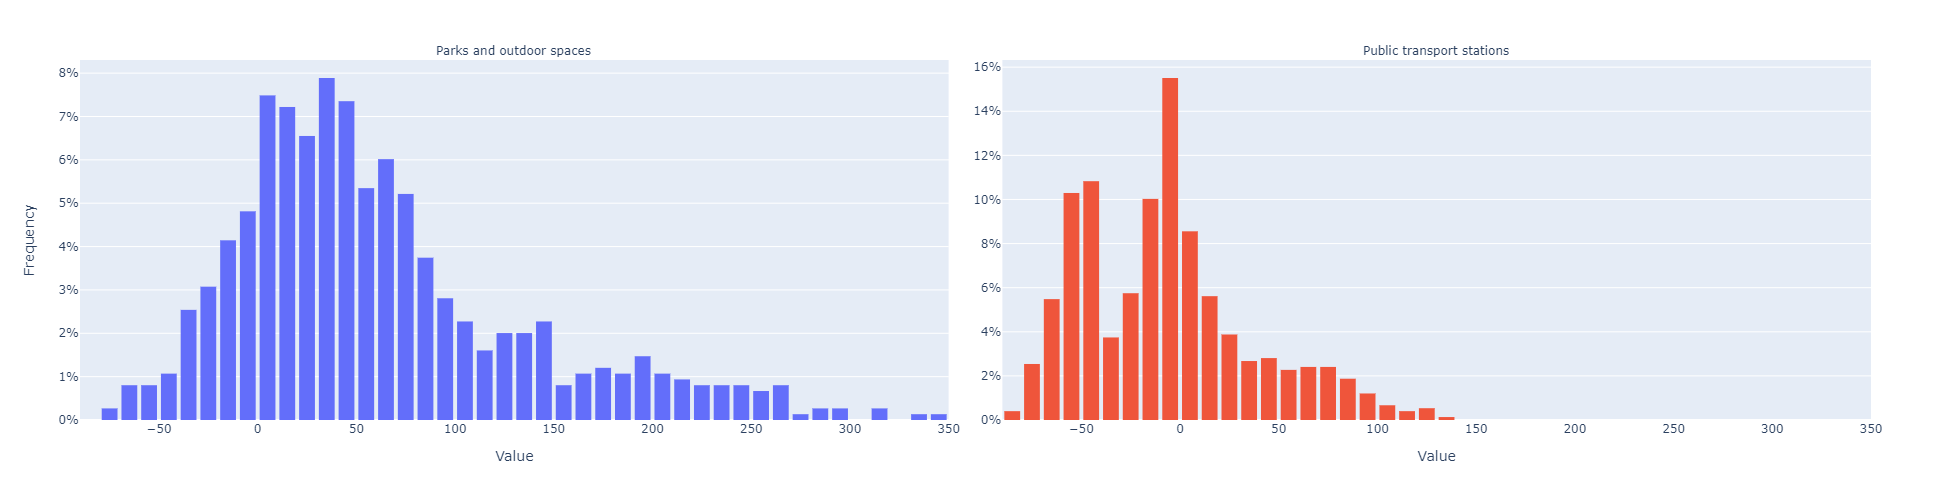

In [17]:
fig = px.histogram(
    data_frame=google,
    x=skewed_cols,
    histnorm='percent',
    nbins=50,
    facet_col='variable',
    facet_col_wrap=2,
    facet_col_spacing=0.03,
    width=600 * len(skewed_cols),
    height=PLOT_HEIGHT * len(skewed_cols) / 2,
)
fig.update_layout(
    showlegend=False,
    bargap=0.2,
    yaxis=dict(title_text="Frequency"),
)
fig.update_xaxes(title_text="Value", position=0.5)
fig.update_yaxes(matches=None, showticklabels=True, ticksuffix="%")
fig.for_each_annotation(
    lambda a: a.update(
        text=helper.TITLES[google.columns.get_loc(a.text.split("=")[-1]) - 1]
    )
)

fig.show()
# fig.write_image("../plots/Skewed Features (Histogram).svg")

## Check Correlations

In [18]:
# To better capture non-linear relationships and reduce effects from outliers we use Speraman's rank correlation
corr = google.iloc[:, 1:-3].corr(method="spearman")

labels = np.where(
    np.abs(corr) > 0.90,
    "VS",
    np.where(np.abs(corr) > 0.75, "S", np.where(np.abs(corr) > 0.55, "M", np.where(np.abs(corr) > 0.30, "W", ""))),
)

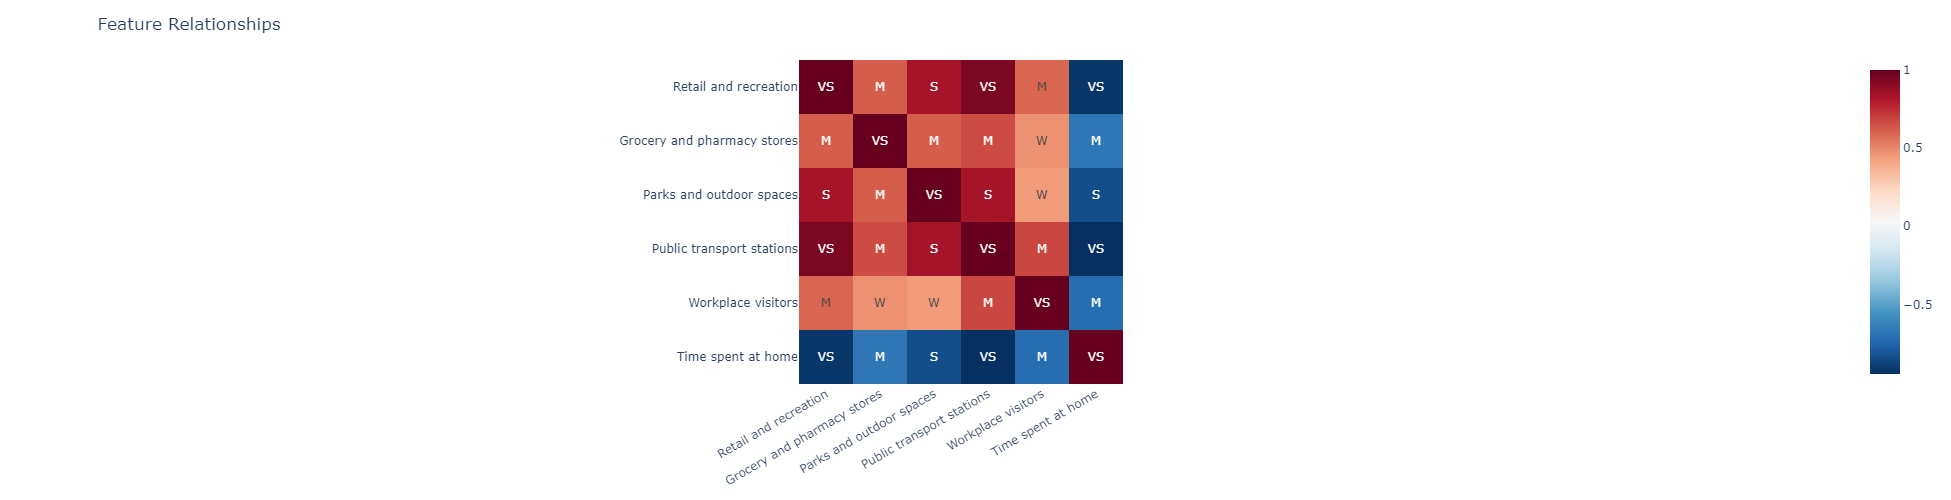

In [19]:
fig = px.imshow(
    corr, 
    width=PLOT_WIDTH, height=PLOT_HEIGHT, 
    text_auto='.2f', color_continuous_scale='RdBu_r')

fig.update_layout(
    title='Feature Relationships',
    xaxis=dict(
        tickmode='array',
        tickvals=corr.columns,
        ticktext=helper.TITLES,
        tickangle=-30
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=corr.columns,
        ticktext=helper.TITLES,
    )
)
fig.update_traces(text=labels, texttemplate="%{text}")
fig.show()

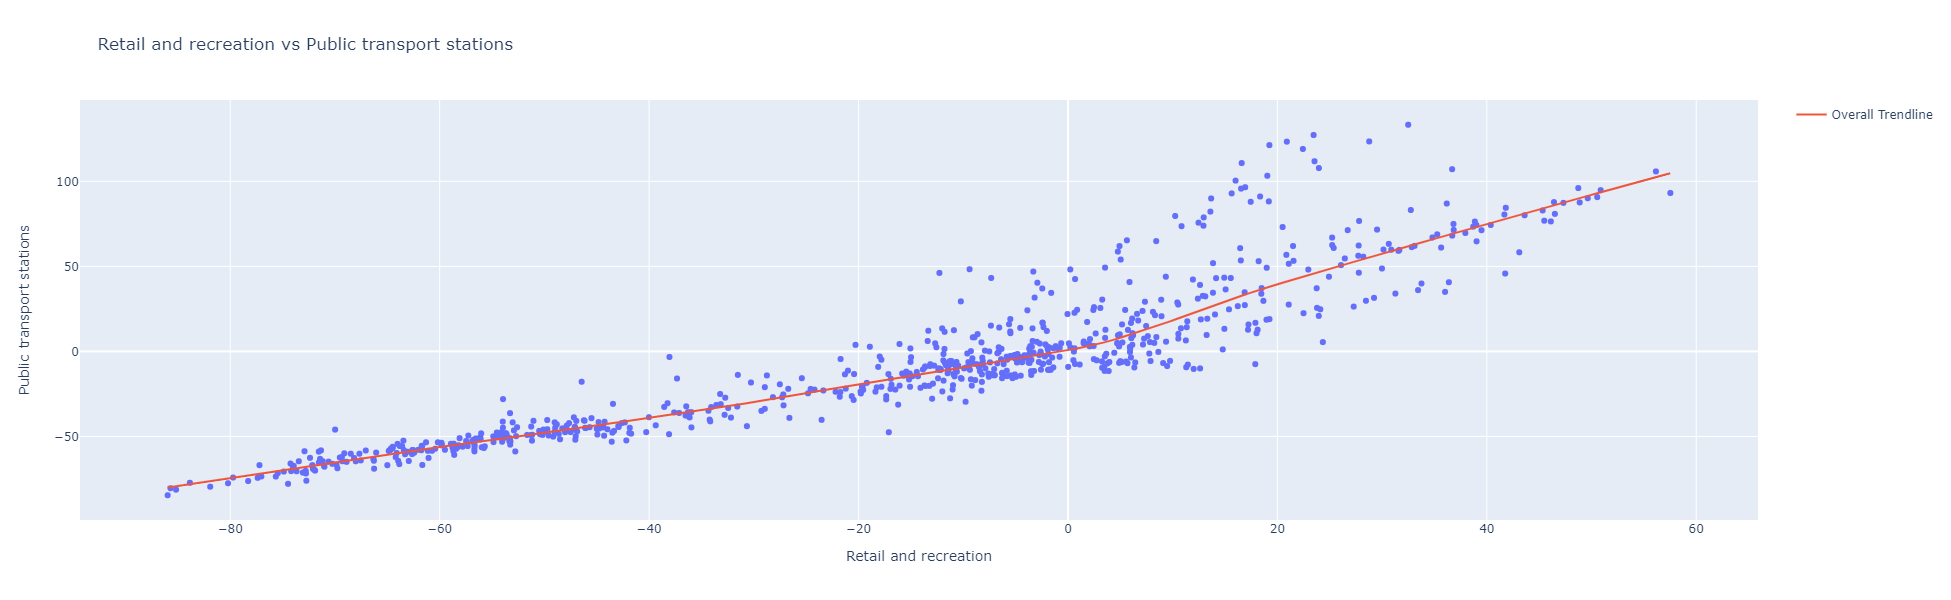

In [ ]:
X = 'retail_and_recreation_percent_change_from_baseline'
Y = 'transit_stations_percent_change_from_baseline'
x_index = google.columns.get_loc(X) - 1
y_index = google.columns.get_loc(Y) - 1

fig = px.scatter(
    data_frame=google,
    x=X,
    y=Y,
    trendline='lowess',
    trendline_scope='overall',
    trendline_options=dict(frac=1/3),
    title=f'{helper.TITLES[x_index]} vs {helper.TITLES[y_index]}',
    labels={
        X: helper.TITLES[x_index],
        Y: helper.TITLES[y_index]
    },
    width=PLOT_WIDTH,
    height=600
)
fig.show()

In [ ]:
x_values = fig.data[1].x
y_values = fig.data[1].y

## Focus on Transit Stations

In [ ]:
ts_transit = google[['date', 'transit_stations_percent_change_from_baseline']].copy()
ts_transit.set_index('date', inplace=True)
ts_transit.index.freq = 'D'

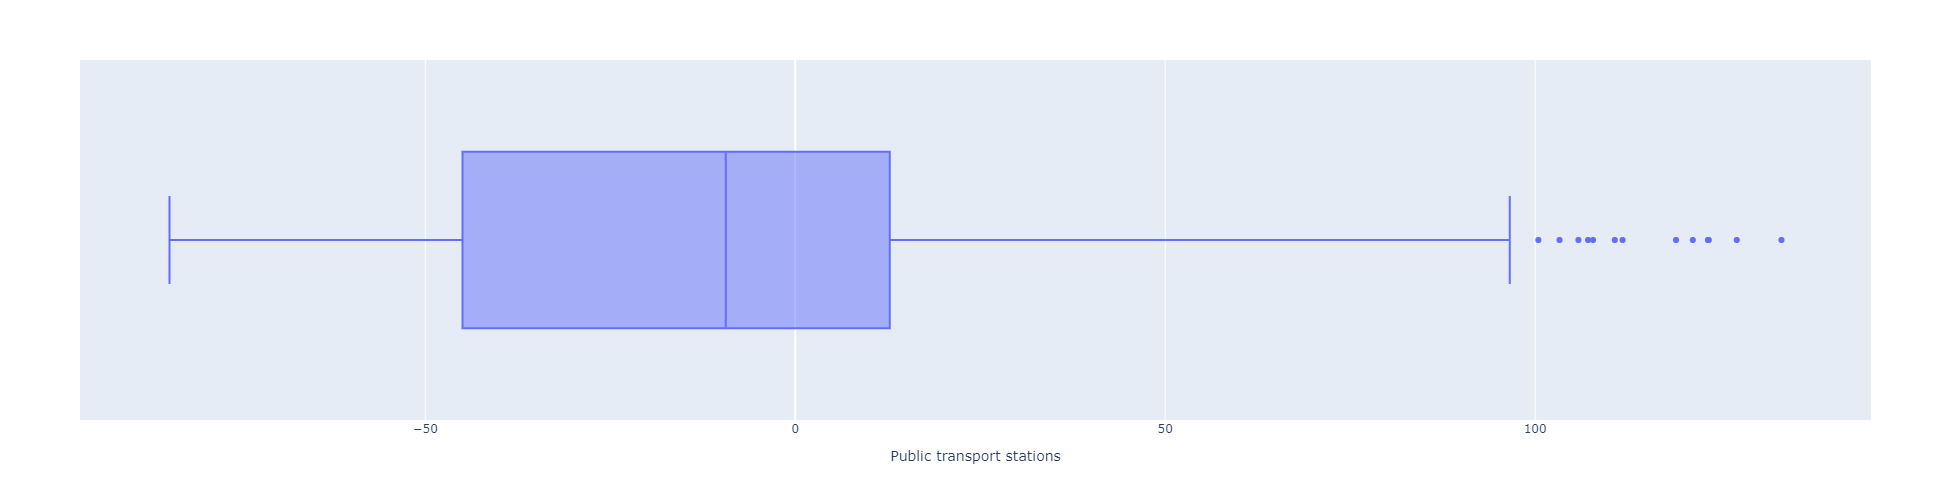

In [ ]:
px.box(
    ts_transit, x='transit_stations_percent_change_from_baseline', 
    labels={'transit_stations_percent_change_from_baseline': helper.TITLES[3]},
    width=PLOT_WIDTH, height=PLOT_HEIGHT
)

### Boxcox Transformation

In [ ]:
trans = ts_transit['transit_stations_percent_change_from_baseline'] + np.abs(ts_transit['transit_stations_percent_change_from_baseline'].min()) + 1
trans, lmbda = boxcox(trans)
trans = pd.DataFrame(data=trans, index=ts_transit.index).rename(columns={0: 'transit_stations_percent_change_from_baseline'})

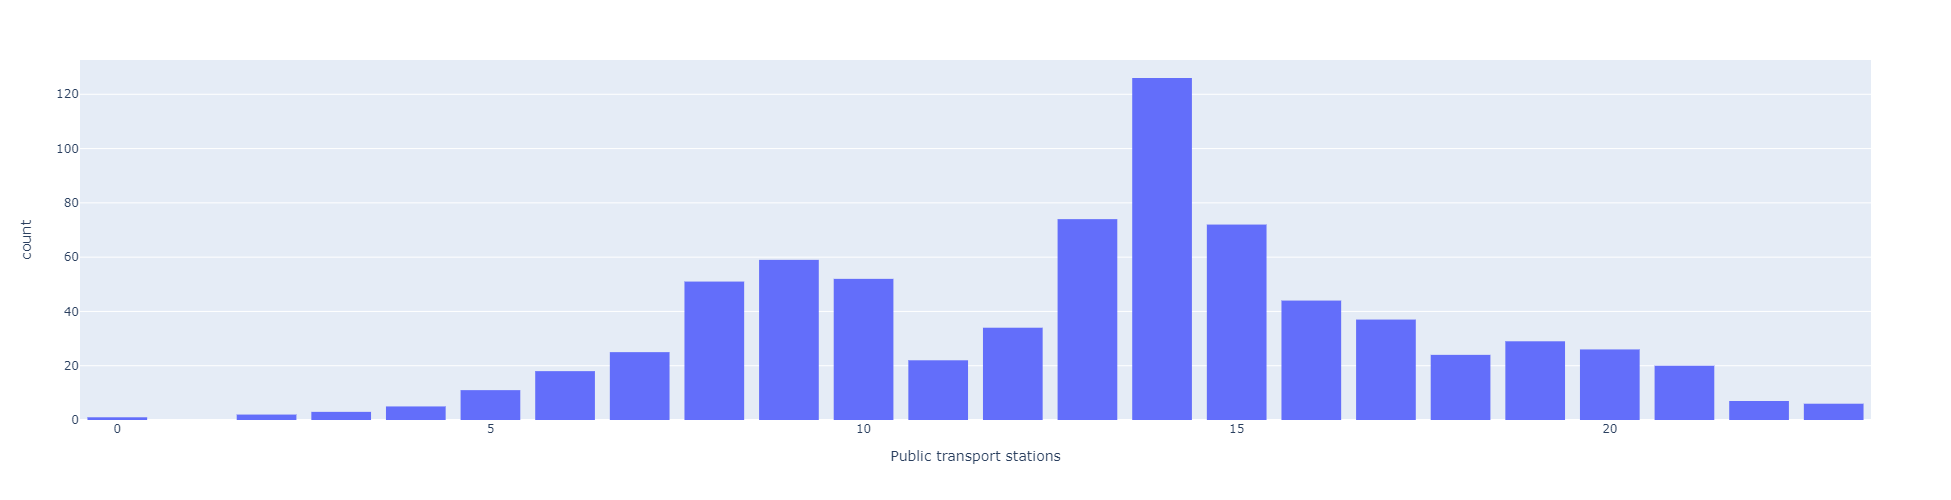

In [ ]:
fig = px.histogram(
    trans, 
    x='transit_stations_percent_change_from_baseline', 
    labels={'transit_stations_percent_change_from_baseline': helper.TITLES[3]}, 
    width=PLOT_WIDTH, height=PLOT_HEIGHT
)
fig.update_layout(
    showlegend=False,
    bargap=0.2
)

### Seasonal Decomposition

In [ ]:
result = seasonal_decompose(x=trans, model='additive', period=30, two_sided=False)
trend = result.trend.to_frame()
seasonality = result.seasonal.to_frame()
residual = result.resid.to_frame()

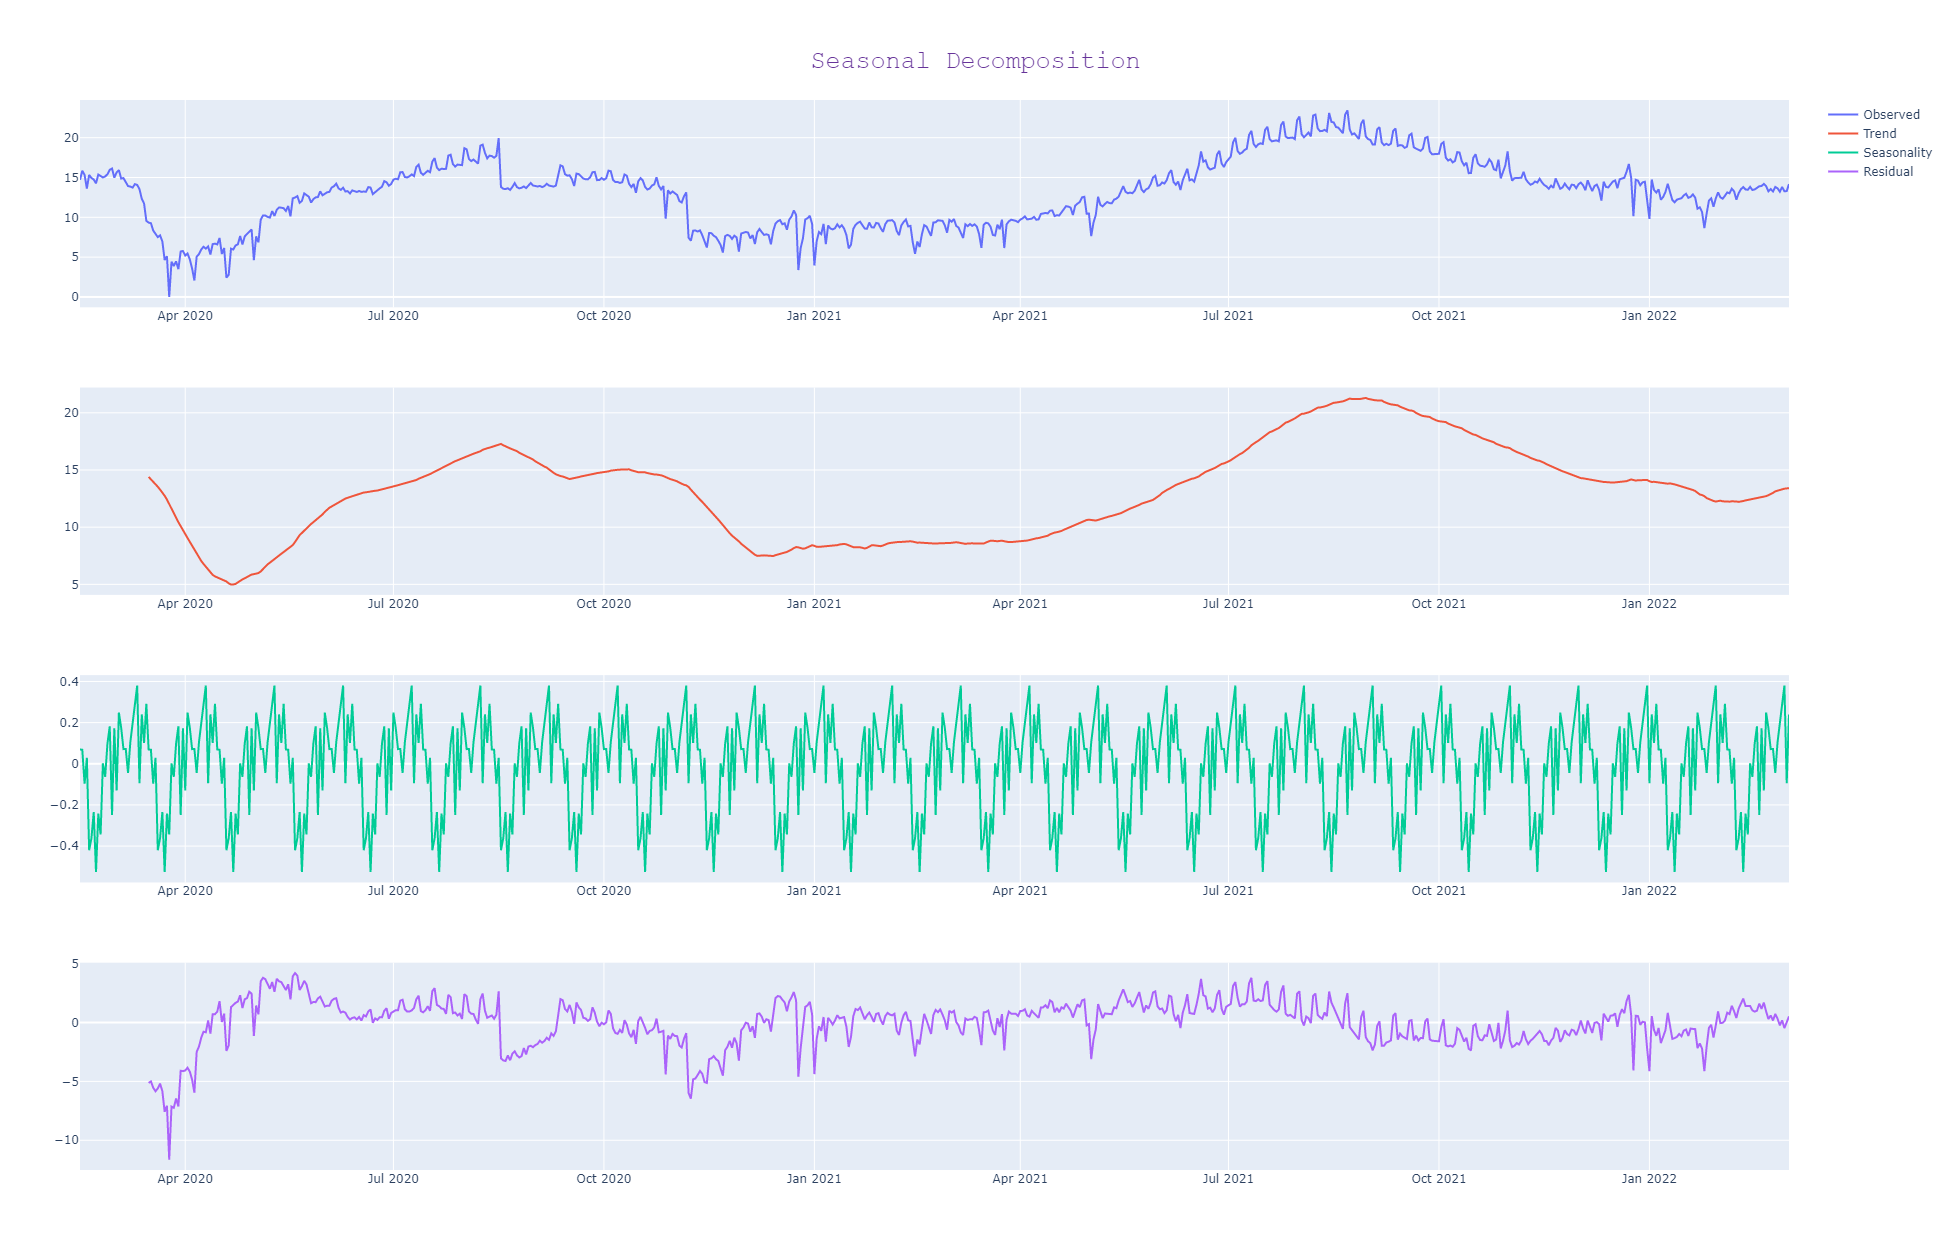

In [ ]:
fig = make_subplots(4, 1)
index = trans.index
fig.add_trace(
    go.Scatter(x=index, y=trans["transit_stations_percent_change_from_baseline"], mode="lines", name="Observed"),
    row=1, col=1,
)

fig.add_trace(
    go.Scatter(x=index, y=trend["trend"], mode="lines", name="Trend"), 
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=index, y=seasonality["seasonal"], mode="lines", name="Seasonality"),
    row=3, col=1,
)

fig.add_trace(
    go.Scatter(x=index, y=residual["resid"], mode="lines", name="Residual"),
    row=4, col=1,
)

fig.update_layout(
    title=dict(
        text="Seasonal Decomposition",
        x=0.5,
        xanchor="center",
        yanchor="top",
        font=dict(family="Courier New, monospace", size=25, color="RebeccaPurple"),
    ),
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT * 2.5,
)


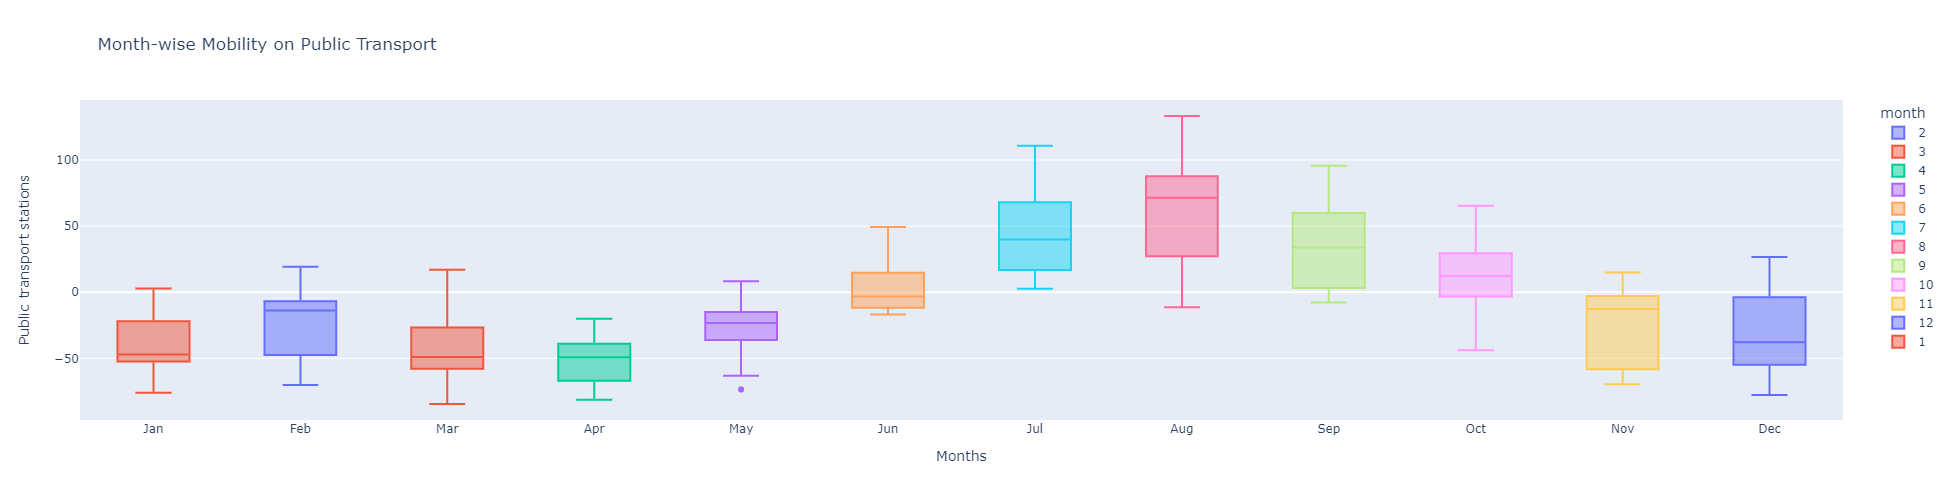

In [ ]:
fig = px.box(
    google, 
    x='month',
    y='transit_stations_percent_change_from_baseline',
    color='month', 
    width=PLOT_WIDTH, height=PLOT_HEIGHT,
    title='Month-wise Mobility on Public Transport'
)

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(1,13)),
        ticktext=[datetime.date(2000, i, 1).strftime('%b') for i in range(1, 13)],
        title_text='Months'
    ),
    yaxis=dict(title_text=helper.TITLES[3])
)

fig.show()
# fig.write_image('../plots/Parks/Monthly Box Plot.svg')

### Check Stationarity

#### Augmented Dickey-Fuller Test

In [29]:
time_series = trans.copy()
d = 0

while helper.test_stationarity(time_series, nlags=d, confidence=0.01):
    time_series = time_series.diff().dropna()
    d += 1

 > Is the 0-lag data stationary ?
Test statistic = -2.020
P-value = 0.278
Num of Lags = 20.000
Critical values :
	1%: -3.439376877165393 - The data is not stationary with 99% confidence
 > Is the 1-lag data stationary ?
Test statistic = -5.204
P-value = 0.000
Num of Lags = 20.000
Critical values :
	1%: -3.4393893552577723 - The data is  stationary with 99% confidence


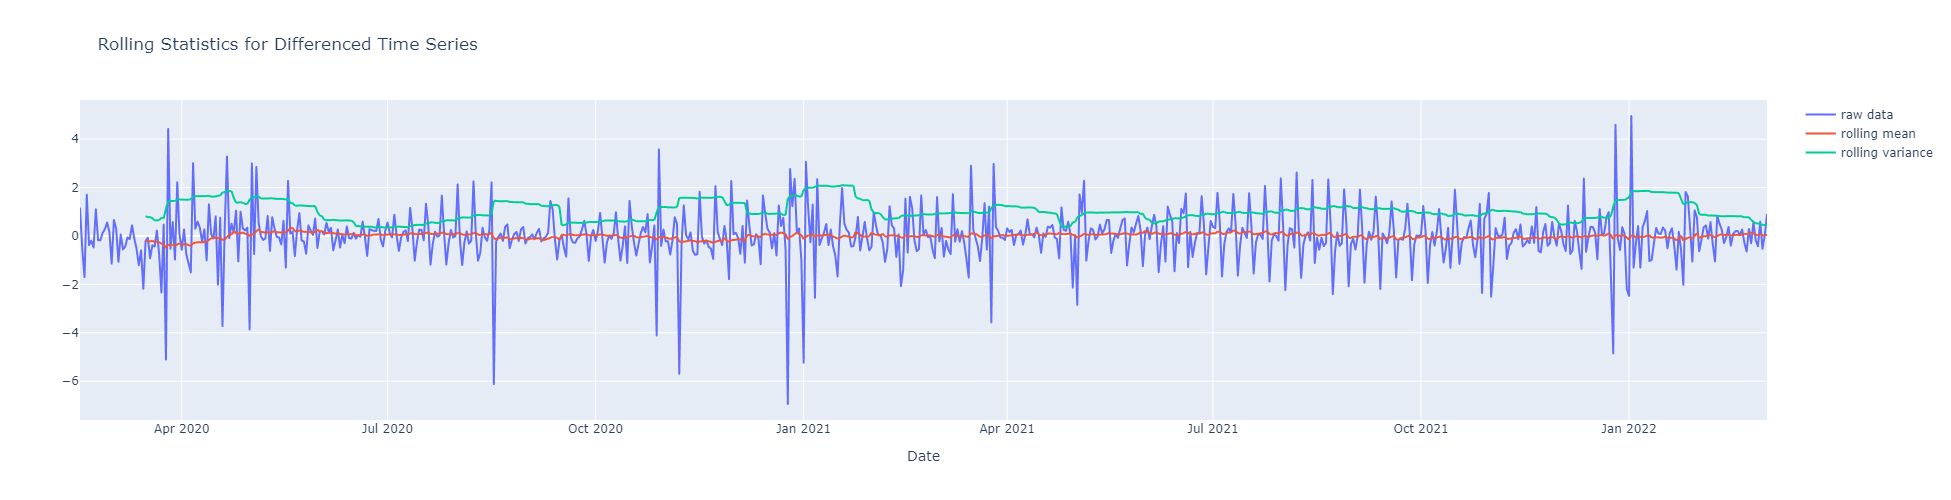

In [32]:
fig = px.line(
    data_frame=time_series,
    # x=time_series.index.values,
    y=['transit_stations_percent_change_from_baseline',
       time_series.rolling(window=30).mean()['transit_stations_percent_change_from_baseline'],
       time_series.rolling(window=30).std()['transit_stations_percent_change_from_baseline'],
    ],
    labels={"date": "Date", "value": "", "variable": ""},
    title='Rolling Statistics for Differenced Time Series',
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)
fig.data[0].name = "raw data"
fig.data[1].name = "rolling mean"
fig.data[2].name = "rolling variance"

fig.show()
# fig.write_image("../plots/Parks/Rolling Statistics.svg")

#### Autocorrelation plots (ACF & PACF)

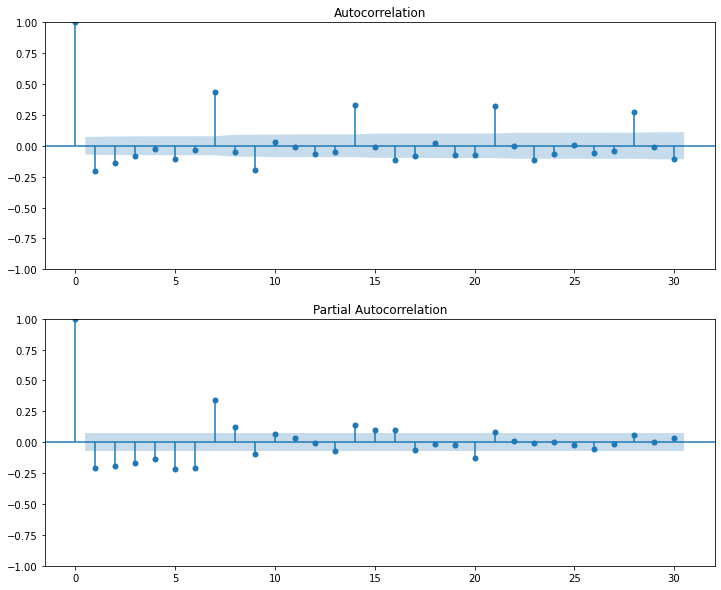

In [33]:
FIG_SIZE = (12, 10)

fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE)
plot_acf(time_series, ax=ax[0], lags=30)
plot_pacf(time_series, ax=ax[1], lags=30, method='ols')
plt.show()

### Building the SARIMA Model

#### Grid Search for optimal parameters

In [35]:
train_size = int(len(time_series) * 0.8)
train_data = trans[:train_size]
test_data = trans[train_size:]

In [36]:
p = (0, 1, 2, 3)
d = 1
q = (0, 1)
P = (0, 1, 2, 3)
D = 1
Q = (0, 1)
s = (7, 30)

parameters = product(p, q, P, Q, s)
parameters_list = list(parameters)

In [40]:
result_df = helper.optimize_SARIMA(parameters_list, d, D, time_series)
result_df

 62%|███████████████████████████████████████████████████████████████████████████▋                                             | 80/128 [17:38<31:50, 39.79s/it]C:\Users\User\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 64%|█████████████████████████████████████████████████████████████████████████████▌                                           | 82/128 [17:42<15:52, 20.71s/it]C:\Users\User\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 66%|███████████████████████████████████████████████████████████████████████████████▍                                         | 84/128 [18:00<11:12, 15.28s/it]C:\Users\User\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible start

,"(p,q)x(P,Q)",AIC
0,"(3, 1, 3, 1, 7)",2006.793385
1,"(3, 1, 1, 1, 7)",2015.656212
2,"(3, 1, 2, 1, 7)",2017.670980
3,"(3, 1, 0, 1, 7)",2021.892921
4,"(2, 1, 3, 1, 7)",2024.076296
...,...,...
123,"(0, 0, 0, 0, 7)",3017.531375
124,"(2, 0, 0, 0, 30)",3031.531473
125,"(0, 0, 1, 0, 30)",3066.406760
126,"(1, 0, 0, 0, 30)",3195.838276


#### Training the optimal SARIMA Model

In [37]:
best_model = SARIMAX(train_data, order=(3, d, 1), seasonal_order=(3, D, 1, 7)).fit(disp=-1)
print(best_model.summary())

                                             SARIMAX Results                                             
Dep. Variable:     transit_stations_percent_change_from_baseline   No. Observations:                  597
Model:                             SARIMAX(3, 1, 1)x(3, 1, 1, 7)   Log Likelihood                -797.009
Date:                                           Thu, 24 Mar 2022   AIC                           1612.018
Time:                                                   17:37:36   BIC                           1651.424
Sample:                                               02-15-2020   HQIC                          1627.371
                                                    - 10-03-2021                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

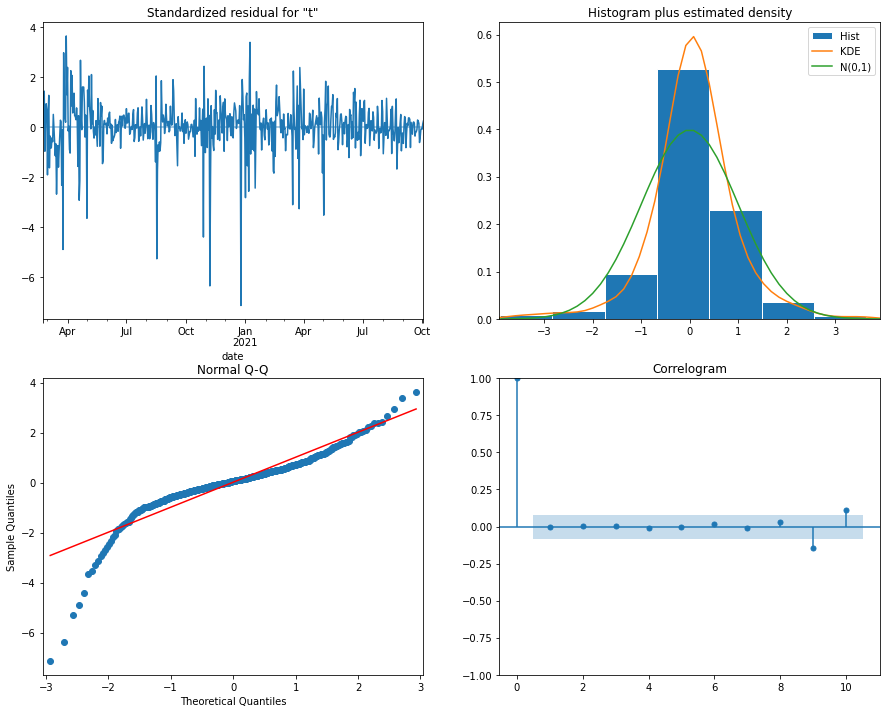

In [38]:
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [57]:
forecast_values = best_model.get_forecast(steps = test_data.shape[0])

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

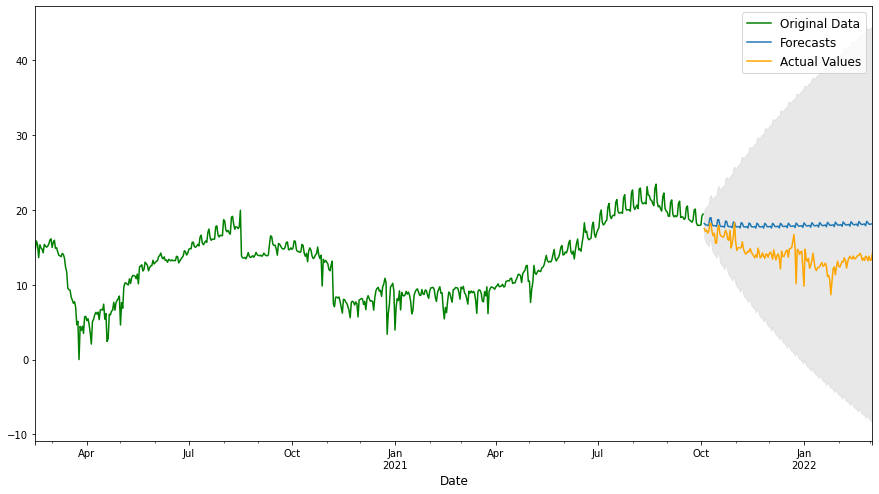

In [62]:
#Plot the data
ax = train_data.plot(y='transit_stations_percent_change_from_baseline', figsize=(15, 8), label='Original Data', color='g')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecasts', figsize = (15, 8), grid=True)
test_data.plot(ax=ax, y='transit_stations_percent_change_from_baseline', figsize=(15, 8), label='Actual Values', color='orange')
#Plot the confidence intervals
ax.fill_between(forecast_ci.index, forecast_ci.iloc[: , 0], forecast_ci.iloc[: , 1], color='#D3D3D3', alpha = 0.5)
plt.xlabel('Date', size=12)
plt.legend(loc='upper right', prop={'size': 12})
plt.show()

In [86]:
predictions = np.array([])
mape_list = []
train, test = trans[:train_size], trans[train_size:]
day_list = [7, 14, 21, 28]  # weeks 1,2,3,4

In [88]:
for i in day_list:
    model = SARIMAX(train, order=(3, 1, 1), seasonal_order=(3, 1, 1, 7)).fit(method="powell")

    # Forecast daily loads for week i
    forecast = model.get_forecast(steps=7)
    predictions = np.concatenate((predictions, forecast.predicted_mean), axis=None)
    j = i - 7

    # mape_score = (abs(test[j:i] - predictions[j:i]) / test[j:i]) * 100
    # mape_mean = mape_score.mean()
    # mape_list.append(mape_mean)  # Add week i to training data for next loop
    # train = np.concatenate((train, test[j:i]), axis=None)

Optimization terminated successfully.
         Current function value: 1.336329
         Iterations: 15
         Function evaluations: 1611


ValueError: Unable to coerce to Series, length must be 1: given 7

# Compare behaviour between first and second wave period of the pandemic

In [ ]:
fmt = "%Y-%m-%d"
start_date = datetime.datetime.strptime("2020-03-23", fmt)
end_date = datetime.datetime.strptime("2020-05-04", fmt)

mask = (google["date"] >= start_date) & (google["date"] <= end_date)
fw_mobility = google.loc[mask].reset_index(drop=True)

## Anomaly check in the distributions during the first wave

In [ ]:
cols_of_interest = [col for col in fw_mobility.columns[1:-3]]

fig = px.histogram(
    data_frame=google,
    x=cols_of_interest,
    histnorm='percent',
    nbins=50,
    facet_col='variable',
    facet_col_wrap=3,
    facet_col_spacing=0.03,
    width=len(skewed_cols) * 600,
    height=PLOT_HEIGHT * 2,
)
fig.update_layout(showlegend=False, bargap=0.2,
fig.update_xaxes(title_text="Value", position=0.5)
fig.update_yaxes(title_text="Frequency", matches=None, showticklabels=True, ticksuffix="%")
fig.for_each_annotation(
    lambda a: a.update(
        text=helper.TITLES[google.columns.get_loc(a.text.split("=")[-1]) - 1]
    )
)

fig.show()
# fig.write_image("../plots/Skewed Features (Histogram).svg")